# Cats and Dogs Binary Classification

This notebook will train, quantize, and synthesis the Cats and Dogs example. We want to use this example to show that a high test set accuracy does not guarantee a high accuracy on the board.

## Import the necessary modules and define some helper functions

In [1]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
# modules from subdirectories
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

# import models and datasets
from classification import *
mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

## Define Training Configurations (args)

In [2]:
class Config:
    def __init__(self):
        self.dataset_name = "cats_and_dogs"
        self.dataset_fn = cats_and_dogs_get_datasets
        self.num_classes = 2
        self.model_name = "catdognet"
        self.dimensions = (3,128,128)
        self.workers = 4
        self.batch_size = 32
        self.validation_split = 0.1
        self.log_prefix = "high_acc_b32_long_train"
        self.log_dir = "jupyter_logging"
        self.data_path = "../Datasets/cats_and_dogs/"
        self.deterministic = True
        self.print_freq = 100
        self.labels = ('dog', 'cat')
        self.lr = 0.001
        self.num_epochs = 2000
        self.qat_policy = {'start_epoch':10, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args

conf = Config()

## Set up the logger

In [3]:
msglogger = apputils.config_pylogger('logging.conf', conf.log_prefix, conf.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf.dataset_name,conf.dataset_fn,conf.num_classes,conf.model_name,conf.dimensions,conf.batch_size,conf.validation_split,conf.lr,conf.num_epochs,conf.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/jupyter_logging/high_acc_b32_long_train___2022.06.30-115449/high_acc_b32_long_train___2022.06.30-115449.log
dataset_name:cats_and_dogs
dataset_fn=<function cats_and_dogs_get_datasets at 0x7ff2248135e0>
num_classes=2
model_name=catdognet
dimensions=(3, 128, 128)
batch_size=32
validation_split=0.1
lr=0.001000
num_epochs=2000
qat_policy={'start_epoch': 10, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



## Create and visualize the dataset

In [2]:
s_path = "../Datasets/cats_and_dogs/test"
t_path = "../Datasets/cats_and_dogs_target/test"
g_dataset = DomainAdaptationPairDataset(s_path,t_path,None,4)

../Datasets/cats_and_dogs/test
../Datasets/cats_and_dogs_target/test
../Datasets/cats_and_dogs/test
{'dogs': 0, 'cats': 1}
../Datasets/cats_and_dogs_target/test
{'dogs': 0, 'cats': 1}


In [14]:
g_dataset.G1_img_paths[2480:2600]

[('/home/geffencooper/Model_Development/Datasets/cats_and_dogs/test/dogs/dog.2279.jpg',
  '/home/geffencooper/Model_Development/Datasets/cats_and_dogs/test/cats/cat.2875.jpg'),
 ('/home/geffencooper/Model_Development/Datasets/cats_and_dogs/test/dogs/dog.2087.jpg',
  '/home/geffencooper/Model_Development/Datasets/cats_and_dogs/test/dogs/dog.2087.jpg'),
 ('/home/geffencooper/Model_Development/Datasets/cats_and_dogs/test/dogs/dog.2087.jpg',
  '/home/geffencooper/Model_Development/Datasets/cats_and_dogs/test/dogs/dog.11045.jpg'),
 ('/home/geffencooper/Model_Development/Datasets/cats_and_dogs/test/dogs/dog.2087.jpg',
  '/home/geffencooper/Model_Development/Datasets/cats_and_dogs/test/dogs/dog.4361.jpg'),
 ('/home/geffencooper/Model_Development/Datasets/cats_and_dogs/test/dogs/dog.2087.jpg',
  '/home/geffencooper/Model_Development/Datasets/cats_and_dogs/test/dogs/dog.5575.jpg'),
 ('/home/geffencooper/Model_Development/Datasets/cats_and_dogs/test/dogs/dog.2087.jpg',
  '/home/geffencooper/Mode

In [14]:
sampler = EvenSampler(test_set,shot=5)
for i in sampler:
    print(i)

0
2502
4
2504
3
2503
1
2500
2
2501


../Datasets/cats_and_dogs/train
{'dogs': 0, 'cats': 1}
../Datasets/cats_and_dogs/test
{'dogs': 0, 'cats': 1}


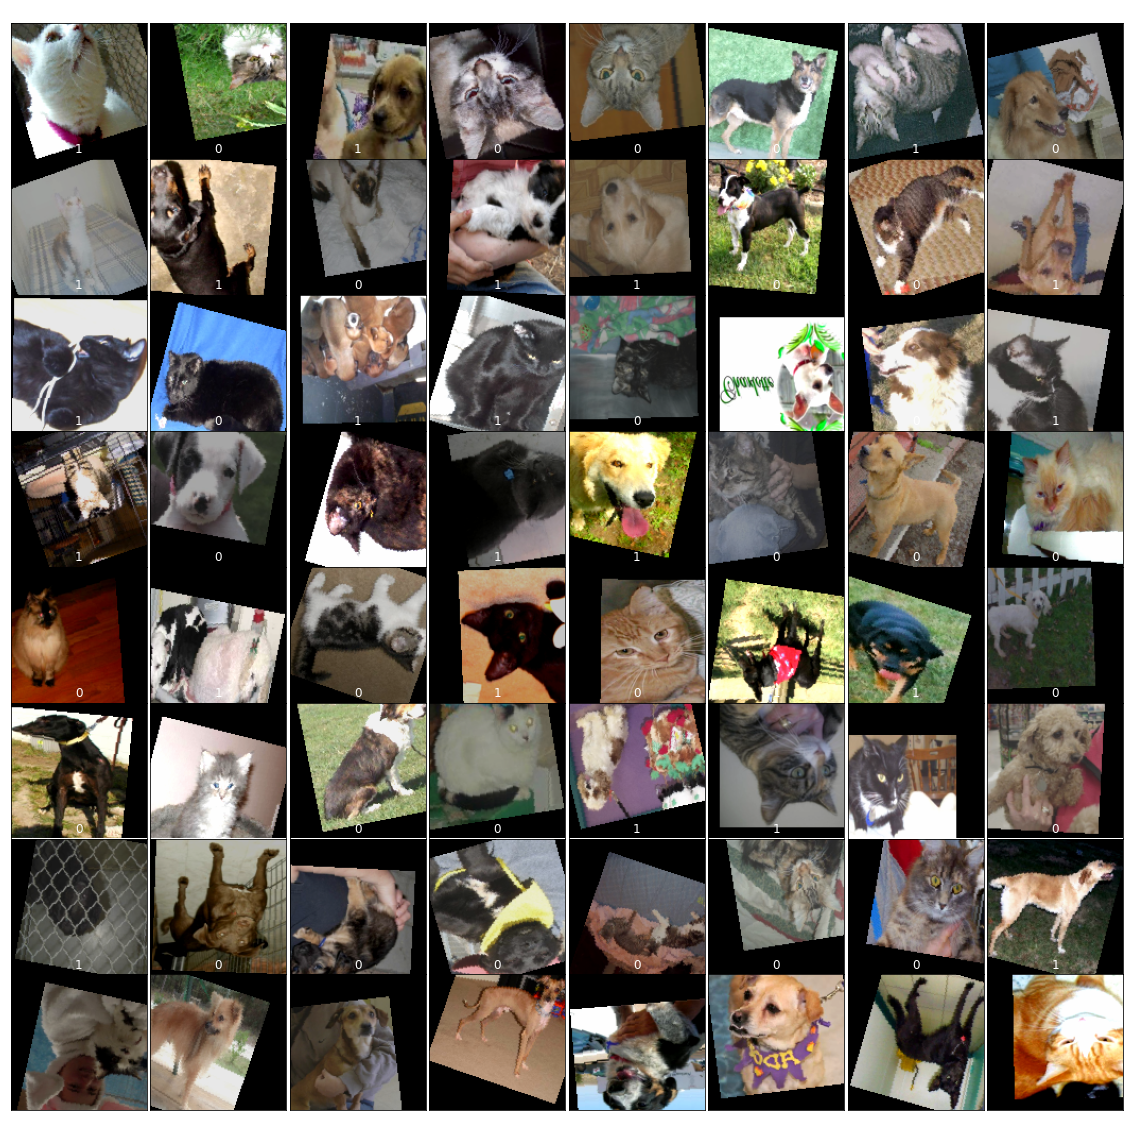

In [4]:
train_set, test_set = conf.dataset_fn((conf.data_path, args), load_train=True, load_test=True)
train_set.visualize_batch()

## Create the data loaders

In [5]:
train_loader, val_loader, test_loader, _ = apputils.get_data_loaders(conf.dataset_fn, (conf.data_path,args), conf.batch_size, conf.workers, conf.validation_split, conf.deterministic,1, 1, 1)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d', len(train_loader.sampler), len(val_loader.sampler), len(test_loader.sampler))
msglogger.info('Augmentations:%s',train_loader.dataset.transform)

Dataset sizes:
	training=18000
	validation=2000
	test=5000
Augmentations:Compose(
    Resize(size=(128, 128), interpolation=bilinear)
    ColorJitter(brightness=(0.65, 1.35), contrast=(0.65, 1.35), saturation=(0.65, 1.35), hue=None)
    RandomAffine(degrees=[-20.0, 20.0], translate=(0.25, 0.25))
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    ToTensor()
)


../Datasets/cats_and_dogs/train
{'dogs': 0, 'cats': 1}
../Datasets/cats_and_dogs/test
{'dogs': 0, 'cats': 1}


## Set up the device, cuda or cpu

In [6]:
conf.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(conf.device))

Running on device: cuda:0


## Set up the model for training

In [7]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the model
model = mod.CatsAndDogsClassifier()
msglogger.info('model: %s',model)
model = model.to(conf.device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input = torch.randn((1, ) + conf.dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input, ), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

model: CatsAndDogsClassifier(
  (conv1): FusedConv2dReLU(
    (activate): ReLU(inplace=True)
    (op): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (calc_out_shift): OutputShiftSqueeze()
    (calc_weight_scale): One()
    (scale): Scaler()
    (calc_out_scale): OutputScale()
    (quantize_weight): Empty()
    (quantize_bias): Empty()
    (clamp_weight): Empty()
    (clamp_bias): Empty()
    (quantize): Empty()
    (clamp): Clamp()
    (quantize_pool): Empty()
    (clamp_pool): Empty()
  )
  (conv2): FusedConv2dReLU(
    (activate): ReLU(inplace=True)
    (op): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (calc_out_shift): OutputShiftSqueeze()
    (calc_weight_scale): One()
    (scale): Scaler()
    (calc_out_scale): OutputScale()
    (quantize_weight): Empty()
    (quantize_bias): Empty()
    (clamp_weight): Empty()
    (clamp_bias): Empty()
    (quantize): Empty()
    (clamp): Clamp()
    (quantize_pool): Empty()
  

Configuring device: MAX78000, simulate=False.


Number of Model Params: 88522


## Set up optimizer, loss, and learning schedule

In [8]:
# optimizer
conf.optimizer = optim.Adam(model.parameters(), lr=conf.lr)
msglogger.info('Optimizer Type: %s', type(conf.optimizer))

# lr schedule
conf.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf.optimizer, milestones=[10, 35,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf.lr_scheduler.base_lrs)+" milestones: "+str(conf.lr_scheduler.milestones)+ " gamma: "+str(conf.lr_scheduler.gamma))

# loss function
conf.criterion = torch.nn.CrossEntropyLoss().to(conf.device)
compression_scheduler = distiller.CompressionScheduler(model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({10: 1, 35: 1, 100: 1}) gamma: 0.5


## Validation Function

In [9]:
def validate(data_loader, model, loggers, conf, epoch=-1, tflogger=None):
    """Execute the validation/test loop."""

    # keep track of incorrect predictions
    wrong_samples = None
    wrong_preds = None
    actual_preds = None
    img_names = None

    # store loss stats
    losses = {'objective_loss': tnt.AverageValueMeter()}
    classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf.num_classes, 5)))

    # validation set info
    total_samples = len(data_loader.sampler)
    confusion = tnt.ConfusionMeter(conf.num_classes)
    total_steps = (total_samples + conf.batch_size - 1) // conf.batch_size
    msglogger.info('%d samples (%d per mini-batch)', total_samples, conf.batch_size)

    # Switch to evaluation mode
    model.eval()

    class_probs = []
    class_preds = []

    # iterate over the batches in the validation set
    for validation_step, (inputs, target, names) in enumerate(data_loader):
        with torch.no_grad():
            inputs, target = inputs.to(conf.device), target.to(conf.device)

            # compute output from model
            output = model(inputs)

            # # get the idxs of the max output
            # pred = output.argmax(dim=1, keepdim=True)
            
            # wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0] # get wrong predictions
            
            # if validation_step == 0:
            #     wrong_samples = inputs[wrong_idx]
            #     wrong_preds = pred[wrong_idx]
            #     actual_preds = target.view_as(pred)[wrong_idx]
            #     img_names = [names[i.item()] for i in wrong_idx] #names[wrong_idx]
            # else:
            #     wrong_samples = torch.cat((wrong_samples,inputs[wrong_idx]),0)
            #     wrong_preds = torch.cat((wrong_preds,pred[wrong_idx]),0)
            #     actual_preds = torch.cat((actual_preds,target.view_as(pred)[wrong_idx]),0)
            #     img_names.extend([names[i.item()] for i in wrong_idx])

            # compute loss
            loss = conf.criterion(output, target)

            # measure accuracy and record loss
            losses['objective_loss'].add(loss.item())
            classerr.add(output.data, target)
            confusion.add(output.data, target)

            # store prediction stats
            steps_completed = (validation_step+1)
            if steps_completed % conf.print_freq == 0 or steps_completed == total_steps:
                class_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in output]
                _, class_preds_batch = torch.max(output, 1)
                class_probs.append(class_probs_batch)
                class_preds.append(class_preds_batch)

                stats = (
                    '',
                    OrderedDict([('Loss', losses['objective_loss'].mean),
                                 ('Top1', classerr.value(1))])
                )
                if conf.num_classes > 5:
                    stats[1]['Top5'] = classerr.value(5)

                distiller.log_training_progress(stats, None, epoch, steps_completed, total_steps, conf.print_freq, loggers)

    if conf.num_classes > 5:
        msglogger.info('==> Top1: %.3f    Top5: %.3f    Loss: %.3f\n', classerr.value()[0], classerr.value()[1], losses['objective_loss'].mean)
    else:
        msglogger.info('==> Top1: %.3f    Loss: %.3f\n', classerr.value()[0], losses['objective_loss'].mean)

    msglogger.info('==> Confusion:\n%s\n', str(confusion.value()))
    if tflogger is not None:
        cf = nnplot.confusion_matrix(confusion.value(), conf.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix', cf, epoch,
                                            dataformats='HWC')
    # if epoch > 0:
    #     data_loader.dataset.viz_mispredict(wrong_samples,wrong_preds,actual_preds,img_names)
    return classerr.value(1), classerr.value(min(conf.num_classes, 5)), losses['objective_loss'].mean

## Training Function

In [10]:
def train(train_loader, val_loader, test_loader, model, conf):

    # store model history across epochs
    perf_scores_history = []
    model = model.to(conf.device)

    # start the clock
    tic = datetime.now()

    # =============================== training loop =====================================
    for epoch in range(0, conf.num_epochs):
        # check if need to switch to QAT
        if epoch > 0 and epoch == conf.qat_policy['start_epoch']:
            print('QAT is starting!')
            # Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
            ai8x.fuse_bn_layers(model)

            # Switch model from unquantized to quantized for QAT
            ai8x.initiate_qat(model, conf.qat_policy)

            # Model is re-transferred to GPU in case parameters were added
            model.to(conf.device)

            # Empty the performance scores list for QAT operation
            perf_scores_history = []
            name = f'{conf.model_name}_qat'

        # store loss and training stats
        losses = {'objective_loss': tnt.AverageValueMeter()}
        classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf.num_classes, 5)))

        # logging stats
        total_samples = len(train_loader.sampler)
        steps_per_epoch = (total_samples + conf.batch_size - 1) // conf.batch_size
        msglogger.info('Training epoch: %d samples (%d per mini-batch)', total_samples, conf.batch_size)

        # Switch to train mode
        model.train()
        acc_stats = []

        # =================================== batch loop ===================================
        for train_step, (inputs, target, names) in enumerate(train_loader):
            inputs, target = inputs.to(conf.device), target.to(conf.device)

            # forward pass and loss calculation
            output = model(inputs)
            loss = conf.criterion(output, target)

            # on the last batch store the stats for the epoch
            if train_step >= len(train_loader)-2:
                classerr.add(output.data, target)
                acc_stats.append([classerr.value(1), classerr.value(min(conf.num_classes, 5))])

            # add the loss for each batch
            losses["objective_loss"].add(loss.item())

            # reset the optimizer
            conf.optimizer.zero_grad()

            # backwards pass and parameter update
            loss.backward()
            conf.optimizer.step()

            # track batch stats
            steps_completed = (train_step+1)

            # log stats every 10 batches
            if steps_completed % conf.print_freq == 0 or steps_completed == steps_per_epoch:
                # Log some statistics
                errs = OrderedDict()
                if classerr.n != 0:
                    errs['Top1'] = classerr.value(1)
                    if conf.num_classes > 5:
                        errs['Top5'] = classerr.value(5)
                else:
                    errs['Top1'] = None
                    errs['Top5'] = None

                stats_dict = OrderedDict()
                for loss_name, meter in losses.items():
                    stats_dict[loss_name] = meter.mean
                stats_dict.update(errs)
                
                stats_dict['LR'] = conf.optimizer.param_groups[0]['lr']
                stats = ('Performance/Training/', stats_dict)
                params = None
                distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf.print_freq,all_loggers)


        # ============================= validation =======================
        msglogger.info('--- validate (epoch=%d)-----------', epoch)
        top1, top5, vloss = validate(val_loader, model, [pylogger], conf, epoch, tflogger)

        # store validation stats
        stats = ('Performance/Validation/', OrderedDict([('Loss', vloss), ('Top1', top1)]))
        if conf.num_classes > 5:
            stats[1]['Top5'] = top5

        distiller.log_training_progress(stats, None, epoch, steps_completed=0, total_steps=1,
                                                log_freq=1, loggers=all_tbloggers)

        perf_scores_history.append(distiller.MutableNamedTuple({'top1': top1, 'top5': top5,
                                                                'epoch': epoch}))
        # Keep perf_scores_history sorted from best to worst
        # Sort by top1 as main sort key, then sort by top5 and epoch
        perf_scores_history.sort(key=operator.attrgetter('top1', 'top5', 'epoch'),reverse=True)
        for score in perf_scores_history[:1]:
            if conf.num_classes > 5:
                msglogger.info('==> Best [Top1: %.3f   Top5: %.3f  on epoch: %d]',
                                score.top1, score.top5,score.epoch)
            else:
                msglogger.info('==> Best [Top1: %.3f on epoch: %d]',
                                score.top1, score.epoch)

        # Save the checkpoint
        is_best = epoch == perf_scores_history[0].epoch
        checkpoint_extras = {'current_top1': top1,
                            'best_top1': perf_scores_history[0].top1,
                            'best_epoch': perf_scores_history[0].epoch}

        apputils.save_checkpoint(epoch, conf.model_name, model, optimizer=conf.optimizer,
                                    scheduler=compression_scheduler, extras=checkpoint_extras,
                                    is_best=is_best, name=conf.model_name,
                                    dir=msglogger.logdir)
        conf.lr_scheduler.step()

    # ========================= test ============================
    top1, top5, losses = validate(test_loader, model, conf.criterion, [pylogger],epoch,None)
    msglogger.info('==> Test Set [Top1: %.3f   Top5: %.3f  on test set]', top1, top5)
    msglogger.info('Training time: %s', datetime.now() - tic)

## Train the model

In [ ]:
train(train_loader, val_loader, test_loader, model,conf)

## Visualize Embeddings

In [11]:
def viz_embeddings(test_batch_path,conf,batch_size,trained_model_path,model,to_pred=False):
    _, test_set = conf.dataset_fn((test_batch_path, conf.args), load_train=False, load_test=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    # load the trained model
    ai8x.set_device(device=85, simulate=False, round_avg=False)                      
    checkpoint = torch.load(trained_model_path, map_location=lambda storage, loc: storage)
    ai8x.fuse_bn_layers(model)
    model = apputils.load_lean_checkpoint(model, trained_model_path, model_device=conf.device)
    ai8x.update_model(model)
    model = model.to(conf.device)

    # get a batch of data
    (batch_imgs, batch_labels, names) = next(iter(test_loader))
    batch_imgs,batch_labels = batch_imgs.to(conf.device), batch_labels.to(conf.device)

    # register forward hook to get embedding output
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # get the activations
    model.eval()
    model.fc1.register_forward_hook(get_activation('fc1'))
    preds = model(batch_imgs)
    embds = activation['fc1']

    # get the labels
    batch_label_strings = []
    for idx,label in enumerate(batch_labels):
        batch_label_strings.append(test_set.label_dict[label.item()])

    # log to tensorboard
    tflogger.tblogger.writer.add_embedding(
            embds.to('cpu'),
            metadata=batch_label_strings,
            label_img=batch_imgs.to('cpu'),
            global_step=0
        )

    if to_pred:
        print("batch acc: ",np.sum(np.argmax(preds.to('cpu').detach().numpy(),axis=1) == batch_labels.to('cpu').detach().numpy())/len(batch_imgs))

### 1: Visualize cat and dog clusters from dataset and from camera  
* for the dataset images, set the test_batch_path to ../Datasets/test_batch_d/
* for the camera images, set the test_batch_path to ../Datasets/test_batch/  

We see that for this particular batch of images we get **68.75%** on the **camera** batch and **93.75%** on the **dataset** batch. When visualizing the output embeddings of the CNN encoder we also see that the dataset batch clusters better

In [13]:
# init the model
model = mod.CatsAndDogsClassifier()

# create the embeddings
viz_embeddings("../Datasets/test_batch/",conf,64,"jupyter_logging/high_acc_b32_long_train___2022.06.24-175831/catdognet_qat_best.pth.tar",model,True)

=> loading checkpoint jupyter_logging/high_acc_b32_long_train___2022.06.24-175831/catdognet_qat_best.pth.tar
=> Checkpoint contents:
+----------------------+-------------+-----------+
| Key                  | Type        | Value     |
|----------------------+-------------+-----------|
| arch                 | str         | catdognet |
| compression_sched    | dict        |           |
| epoch                | int         | 1425      |
| extras               | dict        |           |
| optimizer_state_dict | dict        |           |
| optimizer_type       | type        | Adam      |
| state_dict           | OrderedDict |           |
+----------------------+-------------+-----------+

=> Checkpoint['extras'] contents:
+--------------+--------+---------+
| Key          | Type   |   Value |
|--------------+--------+---------|
| best_epoch   | int    | 1425    |
| best_top1    | float  |   94.95 |
| current_top1 | float  |   94.95 |
+--------------+--------+---------+

Loaded compression

../Datasets/test_batch/test
{'dogs': 0, 'cats': 1}
Configuring device: MAX78000, simulate=False.
batch acc:  0.6875


### 2: Visualize difference in domains
* path is ../Datasets/test_batch4  

From the embeddings we can see that there is a shift between the domains, e.g. all the cat images should cluster together rather than form independent clusters based on the domain

In [14]:
# init the model
model = mod.CatsAndDogsClassifier()

# create the embeddings
viz_embeddings("../Datasets/test_batch4/",conf,128,"jupyter_logging/high_acc_b32_long_train___2022.06.24-175831/catdognet_qat_best.pth.tar",model,False)

=> loading checkpoint jupyter_logging/high_acc_b32_long_train___2022.06.24-175831/catdognet_qat_best.pth.tar
=> Checkpoint contents:
+----------------------+-------------+-----------+
| Key                  | Type        | Value     |
|----------------------+-------------+-----------|
| arch                 | str         | catdognet |
| compression_sched    | dict        |           |
| epoch                | int         | 1425      |
| extras               | dict        |           |
| optimizer_state_dict | dict        |           |
| optimizer_type       | type        | Adam      |
| state_dict           | OrderedDict |           |
+----------------------+-------------+-----------+

=> Checkpoint['extras'] contents:
+--------------+--------+---------+
| Key          | Type   |   Value |
|--------------+--------+---------|
| best_epoch   | int    | 1425    |
| best_top1    | float  |   94.95 |
| current_top1 | float  |   94.95 |
+--------------+--------+---------+

Loaded compression

../Datasets/test_batch4/test
{'cat_dataset': 0, 'dog_camera': 1, 'dog_dataset': 2, 'cat_camera': 3}
Configuring device: MAX78000, simulate=False.


## Quantize the model

You must change the kernel to execute within the ai8x-synthesis virtual environment

In [1]:
%load_ext autoreload
%autoreload 2
%run ../ai8x-synthesis/quantize.py jupyter_logging/high_acc_b32_long_train___2022.06.24-175831/catdognet_qat_best.pth.tar jupyter_logging/high_acc_b32_long_train___2022.06.24-175831/catdognet_qat_best-q.pth.tar --device MAX78000 -v

Configuring device: MAX78000
Converting checkpoint file jupyter_logging/high_acc_b32_long_train___2022.06.24-175831/catdognet_qat_best.pth.tar to jupyter_logging/high_acc_b32_long_train___2022.06.24-175831/catdognet_qat_best-q.pth.tar

Model keys (state_dict):
conv1.output_shift, conv1.weight_bits, conv1.bias_bits, conv1.quantize_activation, conv1.adjust_output_shift, conv1.shift_quantile, conv1.op.weight, conv2.output_shift, conv2.weight_bits, conv2.bias_bits, conv2.quantize_activation, conv2.adjust_output_shift, conv2.shift_quantile, conv2.op.weight, conv3.output_shift, conv3.weight_bits, conv3.bias_bits, conv3.quantize_activation, conv3.adjust_output_shift, conv3.shift_quantile, conv3.op.weight, conv4.output_shift, conv4.weight_bits, conv4.bias_bits, conv4.quantize_activation, conv4.adjust_output_shift, conv4.shift_quantile, conv4.op.weight, conv4.op.bias, conv5.output_shift, conv5.weight_bits, conv5.bias_bits, conv5.quantize_activation, conv5.adjust_output_shift, conv5.shift_quanti

## Evaluate Quantized Model

Change virtual environment back to ai8x-training

In [2]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

from classification import *

mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
load_model_path = 'jupyter_logging/high_acc_b32_long_train___2022.06.24-175831/catdognet_qat_best-q.pth.tar'

# Change this path to match file system layout
data_path = "../Datasets/cats_and_dogs/"

ai8x.set_device(device=85, simulate=True, round_avg=False)

model = mod.CatsAndDogsClassifier()
                          
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(model)
model = apputils.load_lean_checkpoint(model, load_model_path, model_device=device)
ai8x.update_model(model)
model = model.to(device)

Configuring device: MAX78000, simulate=True.


In [7]:
args = Args(act_mode_8bit=True)

_, test_set = cats_and_dogs_get_datasets((data_path, args), load_train=True, load_test=True)
test_dataloader = DataLoader(test_set, batch_size=128, shuffle=False)

../Datasets/cats_and_dogs/train
{'dogs': 0, 'cats': 1}
../Datasets/cats_and_dogs/test
{'dogs': 0, 'cats': 1}


In [8]:
model.eval()
acc = 0.
acc_weight = 0
with torch.no_grad():
    for image, label, name in test_dataloader:
        image = image.to(device)
        label = label.type(torch.long).to(device)
        model_out = model(image)
        label_out = torch.argmax(model_out, dim=1)

        tp = torch.sum(label_out == label)
        acc_batch = (tp / label_out.numel()).detach().item()
        acc += label_out.shape[0] * acc_batch
        acc_weight += label_out.shape[0]

    total_acc = 100 * (acc / acc_weight)
print(f'Quantized accuracy: {total_acc:.2f}%')

Quantized accuracy: 95.46%


## Create a sample image

In [10]:
for image, label,name in test_dataloader:
    break
im_sample = (image[0].detach().cpu().numpy()).astype(np.int64)
np.save('../ai8x-synthesis/tests/sample_cats_and_dogs.npy', im_sample)

## Model Synthesis

In [1]:
%cd ../ai8x-synthesis/
%run ai8xize.py --verbose --log --test-dir sdk/Examples/MAX78000/CNN --prefix cats_and_dogs --checkpoint-file ../ai8x-training/jupyter_logging/high_acc_b32_long_train___2022.06.24-175831/catdognet_qat_best-q.pth.tar --config-file networks/cats_and_dogs.yaml --device MAX78000 --softmax --compact-data --mexpress --timer 0 --fifo --display-checkpoint

/home/geffencooper/Model_Development/ai8x-synthesis


WARNING:

Configuring device: MAX78000
Reading networks/cats_and_dogs.yaml to configure network...
Reading ../ai8x-training/jupyter_logging/high_acc_b32_long_train___2022.06.24-175831/catdognet_qat_best-q.pth.tar to configure network weights...
Checkpoint for epoch 1425, model catdognet - weight and bias data:
 InCh OutCh  Weights         Quant Shift  Min  Max    Size Key                                       Bias       Quant  Min  Max Size Key
    3     8  (24, 3, 3)          8     0  -70   58     216 conv1.op.weight                           N/A            0    0    0    0 N/A                      
    8     8  (64, 3, 3)          8     0 -121  111     576 conv2.op.weight                           N/A            0    0    0    0 N/A                      
    8    16  (128, 3, 3)         8     0  -94   70    1152 conv3.op.weight                           N/A            0    0    0    0 N/A                      
   16    16  (256, 3, 3)         8     0  -89   52    2304 conv4.op.weight          

Cannot check for updates for git branch "DA" from GitHub - Branch not found


WARNING:

cats_and_dogs...
ERROR: The target folder sdk/Examples/MAX78000/CNN/cats_and_dogs exists. Use --overwrite to proceed.


Layer 11: `flatten` is not needed since input dimensions are 1x1.


ERROR:

The target folder sdk/Examples/MAX78000/CNN/cats_and_dogs exists. Use --overwrite to proceed.


AssertionError: 

# Now we do domain adaptation to improve the results

### Set up the discriminator

In [57]:
# load the encoder-classifier model
load_model_path = "jupyter_logging/high_acc_b32_long_train___2022.06.24-175831/catdognet_qat_best.pth.tar"
model = mod.CatsAndDogsClassifier()                       
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(model)
model = apputils.load_lean_checkpoint(model, load_model_path, model_device=conf.device)
ai8x.update_model(model)
model = model.to(conf.device)

# register a forward hook to get the encoder output
encoder_output = {}
def get_embedding(name):
    def hook(model, input, output):
        encoder_output[name] = output.detach()
    return hook

# get the activations
model.fc1.register_forward_hook(get_embedding('fc1'))

# create the discriminator
discriminator = mod.CatsAndDogsDCD()
discriminator = discriminator.to(conf.device)

=> loading checkpoint jupyter_logging/high_acc_b32_long_train___2022.06.24-175831/catdognet_qat_best.pth.tar
=> Checkpoint contents:
+----------------------+-------------+-----------+
| Key                  | Type        | Value     |
|----------------------+-------------+-----------|
| arch                 | str         | catdognet |
| compression_sched    | dict        |           |
| epoch                | int         | 1425      |
| extras               | dict        |           |
| optimizer_state_dict | dict        |           |
| optimizer_type       | type        | Adam      |
| state_dict           | OrderedDict |           |
+----------------------+-------------+-----------+

=> Checkpoint['extras'] contents:
+--------------+--------+---------+
| Key          | Type   |   Value |
|--------------+--------+---------|
| best_epoch   | int    | 1425    |
| best_top1    | float  |   94.95 |
| current_top1 | float  |   94.95 |
+--------------+--------+---------+

Loaded compression

## Load the data

In [67]:
X_s,Y_s = create_source_samples("../Datasets/cats_and_dogs/",args)
X_t,Y_t = create_target_samples(8,"../Datasets/cats_and_dogs_target/",args)

../Datasets/cats_and_dogs/train
{'dogs': 0, 'cats': 1}
../Datasets/cats_and_dogs_target/train
{'dogs': 0, 'cats': 1}


## Train the domain class discriminator

step2----Epoch 1/400 loss:1.402
step2----Epoch 2/400 loss:1.391
step2----Epoch 3/400 loss:1.331
step2----Epoch 4/400 loss:1.296
step2----Epoch 5/400 loss:1.273
step2----Epoch 6/400 loss:1.229
step2----Epoch 7/400 loss:1.183
step2----Epoch 8/400 loss:1.241
step2----Epoch 9/400 loss:1.117
step2----Epoch 10/400 loss:1.132
step2----Epoch 11/400 loss:1.092
step2----Epoch 12/400 loss:1.131
step2----Epoch 13/400 loss:1.097
step2----Epoch 14/400 loss:1.059
step2----Epoch 15/400 loss:0.959
step2----Epoch 16/400 loss:0.945
step2----Epoch 17/400 loss:1.022
step2----Epoch 18/400 loss:0.916
step2----Epoch 19/400 loss:0.938
step2----Epoch 20/400 loss:0.890
step2----Epoch 21/400 loss:0.938
step2----Epoch 22/400 loss:1.009
step2----Epoch 23/400 loss:0.874
step2----Epoch 24/400 loss:0.900
step2----Epoch 25/400 loss:0.858
step2----Epoch 26/400 loss:0.813
step2----Epoch 27/400 loss:0.859
step2----Epoch 28/400 loss:0.928
step2----Epoch 29/400 loss:0.885
step2----Epoch 30/400 loss:0.964
step2----Epoch 31/4

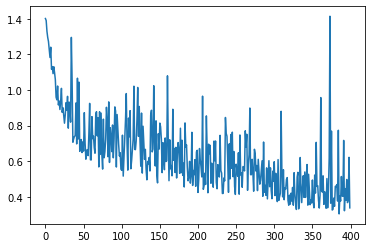

In [59]:
optimizer_D=torch.optim.Adam(discriminator.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss()

epoch_loss = []
for epoch in range(400):
    # data
    groups,aa = create_groups(X_s,Y_s,X_t,Y_t,shot=4,seed=epoch)

    n_iters = 4 * len(groups[1])
    index_list = torch.randperm(n_iters)
    mini_batch_size=32 #use mini_batch train can be more stable


    loss_mean=[]

    X1=[];X2=[];ground_truths=[]
    for index in range(n_iters):
                            #    0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
        # get the class idx --> [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
        ground_truth=index_list[index]//len(groups[1])
        # get the pair by indexing into the groups
        # the first index is the group, the second index is the relative location within the class
        # e.g. idx 5 is the 1st element in class 1 for the example above
        x1,x2=groups[ground_truth][index_list[index]-len(groups[1])*ground_truth]
        X1.append(x1)
        X2.append(x2)
        ground_truths.append(ground_truth)

        #select data for a mini-batch to train
        if (index+1)%mini_batch_size==0:
            X1=torch.stack(X1)
            X2=torch.stack(X2)
            ground_truths=torch.LongTensor(ground_truths)
            X1=X1.to(conf.device)
            X2=X2.to(conf.device)
            ground_truths=ground_truths.to(conf.device)

            optimizer_D.zero_grad()
            out1 = model(X1)
            enc1 = encoder_output['fc1']
            out2 = model(X2)
            enc2 = encoder_output['fc1']
            X_cat=torch.cat([enc1,enc2],1)
            y_pred=discriminator(X_cat.detach())
            #print(torch.sum(y_pred.argmax(dim=1)==ground_truths)/mini_batch_size)
            loss=loss_fn(y_pred,ground_truths)
            loss.backward()
            optimizer_D.step()
            loss_mean.append(loss.item())
            X1 = []
            X2 = []
            ground_truths = []

    print("step2----Epoch %d/%d loss:%.3f"%(epoch+1,400,np.mean(loss_mean)))
    epoch_loss.append(np.mean(loss_mean))
plt.plot(epoch_loss)

## Now do adversarial training to trick the discriminator

In [60]:
train_set, test_set = cats_and_dogs_get_datasets(("../Datasets/cats_and_dogs_target/", args), load_train=False, load_test=True,apply_transforms=False)
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

../Datasets/cats_and_dogs_target/test
{'dogs': 0, 'cats': 1}


In [61]:
#-------------------training for step 3-------------------
optimizer_g_h=torch.optim.Adam(model.parameters(),lr=0.001)
optimizer_d=torch.optim.Adam(discriminator.parameters(),lr=0.001)

best_acc = 0
for epoch in range(20):
    #---training g and h , DCD is frozen

    groups, groups_y = sample_groups(X_s,Y_s,X_t,Y_t,shot=4,seed=200+epoch)
    G1, G2, G3, G4 = groups
    Y1, Y2, Y3, Y4 = groups_y
    groups_2 = [G2, G4]
    groups_y_2 = [Y2, Y4]

    n_iters = 2 * len(G2)
    index_list = torch.randperm(n_iters)

    n_iters_dcd = 4 * len(G2)
    index_list_dcd = torch.randperm(n_iters_dcd)

    mini_batch_size_g_h = 16 #data only contains G2 and G4 ,so decrease mini_batch
    mini_batch_size_dcd= 32 #data contains G1,G2,G3,G4 so use 40 as mini_batch
    X1 = []
    X2 = []
    ground_truths_y1 = []
    ground_truths_y2 = []
    dcd_labels=[]
    for index in range(n_iters):
        ground_truth=index_list[index]//len(G2)
        x1, x2 = groups_2[ground_truth][index_list[index] - len(G2) * ground_truth]
        y1, y2 = groups_y_2[ground_truth][index_list[index] - len(G2) * ground_truth]
        # y1=torch.LongTensor([y1.item()])
        # y2=torch.LongTensor([y2.item()])
        dcd_label=0 if ground_truth==0 else 2
        X1.append(x1)
        X2.append(x2)
        ground_truths_y1.append(y1)
        ground_truths_y2.append(y2)
        dcd_labels.append(dcd_label)

        if (index+1)%mini_batch_size_g_h==0:
            print("train 1")
            X1=torch.stack(X1)
            X2=torch.stack(X2)
            ground_truths_y1=torch.LongTensor(ground_truths_y1)
            ground_truths_y2 = torch.LongTensor(ground_truths_y2)
            dcd_labels=torch.LongTensor(dcd_labels)
            X1=X1.to(conf.device)
            X2=X2.to(conf.device)
            ground_truths_y1=ground_truths_y1.to(conf.device)
            ground_truths_y2 = ground_truths_y2.to(conf.device)
            dcd_labels=dcd_labels.to(conf.device)

            optimizer_g_h.zero_grad()

            out1 = model(X1)
            enc1 = encoder_output['fc1']
            out2 = model(X2)
            enc2 = encoder_output['fc1']

            X_cat=torch.cat([enc1,enc2],1)
            y_pred_X1=out1
            y_pred_X2=out2
            y_pred_dcd=discriminator(X_cat)

            loss_X1=loss_fn(y_pred_X1,ground_truths_y1)
            loss_X2=loss_fn(y_pred_X2,ground_truths_y2)
            loss_dcd=loss_fn(y_pred_dcd,dcd_labels)

            loss_sum = loss_X1 + loss_X2 + 0.2 * loss_dcd

            loss_sum.backward()
            optimizer_g_h.step()

            X1 = []
            X2 = []
            ground_truths_y1 = []
            ground_truths_y2 = []
            dcd_labels = []


    #----training dcd ,g and h frozen
    X1 = []
    X2 = []
    ground_truths = []
    for index in range(n_iters_dcd):

        ground_truth=index_list_dcd[index]//len(groups[1])

        x1, x2 = groups[ground_truth][index_list_dcd[index] - len(groups[1]) * ground_truth]
        X1.append(x1)
        X2.append(x2)
        ground_truths.append(ground_truth)

        if (index + 1) % mini_batch_size_dcd == 0:
            print("train 2")
            X1 = torch.stack(X1)
            X2 = torch.stack(X2)
            ground_truths = torch.LongTensor(ground_truths)
            X1 = X1.to(conf.device)
            X2 = X2.to(conf.device)
            ground_truths = ground_truths.to(conf.device)

            optimizer_d.zero_grad()

            out1 = model(X1)
            enc1 = encoder_output['fc1']
            out2 = model(X2)
            enc2 = encoder_output['fc1']
            X_cat = torch.cat([enc1, enc2], 1)
            y_pred = discriminator(X_cat.detach())
            loss = loss_fn(y_pred, ground_truths)
            loss.backward()
            optimizer_d.step()
            # loss_mean.append(loss.item())
            X1 = []
            X2 = []
            ground_truths = []

    #testing
    acc = 0
    for data, labels,names in test_dataloader:
        data = data.to(conf.device)
        labels = labels.to(conf.device)
        y_test_pred = model(data)
        acc += (torch.max(y_test_pred, 1)[1] == labels).float().mean().item()

    accuracy = round(acc / float(len(test_dataloader)), 3)

    print("step3----Epoch %d/%d  accuracy: %.3f " % (epoch + 1, 50, accuracy))
    if acc > best_acc:
        best_acc = acc
        print("best acc so far")
        apputils.save_checkpoint(epoch, conf.model_name, model, optimizer=conf.optimizer,
                                            scheduler=compression_scheduler, extras=None,
                                            is_best=True, name=conf.model_name+"_DA",
                                            dir=msglogger.logdir)

Sampling groups
train 1
train 2


Saving checkpoint to: jupyter_logging/high_acc_b32_long_train___2022.06.29-155614/catdognet_DA_checkpoint.pth.tar
Saving checkpoint to: jupyter_logging/high_acc_b32_long_train___2022.06.29-155614/catdognet_DA_checkpoint.pth.tar


step3----Epoch 1/50  accuracy: 0.771 
best acc so far
Sampling groups
train 1
train 2
step3----Epoch 2/50  accuracy: 0.792 
best acc so far
Sampling groups
train 1
train 2
step3----Epoch 3/50  accuracy: 0.771 
Sampling groups
train 1
train 2
step3----Epoch 4/50  accuracy: 0.729 
Sampling groups
train 1
train 2
step3----Epoch 5/50  accuracy: 0.667 
Sampling groups
train 1
train 2
step3----Epoch 6/50  accuracy: 0.562 
Sampling groups
train 1
train 2
step3----Epoch 7/50  accuracy: 0.542 
Sampling groups
train 1
train 2
step3----Epoch 8/50  accuracy: 0.542 
Sampling groups
train 1
train 2
step3----Epoch 9/50  accuracy: 0.521 
Sampling groups
train 1
train 2
step3----Epoch 10/50  accuracy: 0.583 
Sampling groups
train 1
train 2
step3----Epoch 11/50  accuracy: 0.604 
Sampling groups
train 1
train 2
step3----Epoch 12/50  accuracy: 0.604 
Sampling groups
train 1
train 2


Saving checkpoint to: jupyter_logging/high_acc_b32_long_train___2022.06.29-155614/catdognet_DA_checkpoint.pth.tar


step3----Epoch 13/50  accuracy: 0.729 
Sampling groups
train 1
train 2
step3----Epoch 14/50  accuracy: 0.812 
best acc so far
Sampling groups
train 1
train 2
step3----Epoch 15/50  accuracy: 0.750 
Sampling groups
train 1
train 2
step3----Epoch 16/50  accuracy: 0.750 
Sampling groups
train 1
train 2
step3----Epoch 17/50  accuracy: 0.771 
Sampling groups
train 1
train 2
step3----Epoch 18/50  accuracy: 0.729 
Sampling groups
train 1
train 2
step3----Epoch 19/50  accuracy: 0.688 
Sampling groups
train 1
train 2
step3----Epoch 20/50  accuracy: 0.688 


## Visualize embeddings again

In [63]:
# init the model
model = mod.CatsAndDogsClassifier()

# create the embeddings
viz_embeddings("../Datasets/test_batch_d/",conf,64,"jupyter_logging/high_acc_b32_long_train___2022.06.29-155614/catdognet_DA_best.pth.tar",model,True)

=> loading checkpoint jupyter_logging/high_acc_b32_long_train___2022.06.29-155614/catdognet_DA_best.pth.tar
=> Checkpoint contents:
+----------------------+-------------+-----------+
| Key                  | Type        | Value     |
|----------------------+-------------+-----------|
| arch                 | str         | catdognet |
| compression_sched    | dict        |           |
| epoch                | int         | 13        |
| extras               | dict        |           |
| optimizer_state_dict | dict        |           |
| optimizer_type       | type        | Adam      |
| state_dict           | OrderedDict |           |
+----------------------+-------------+-----------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   | Value   |
|-------+--------+---------|
+-------+--------+---------+

Loaded compression schedule from checkpoint (epoch 13)
=> loaded 'state_dict' from checkpoint 'jupyter_logging/high_acc_b32_long_train___2022.06.29-155614/

../Datasets/test_batch_d/test
{'dogs': 0, 'cats': 1}
Configuring device: MAX78000, simulate=False.
batch acc:  0.875


In [65]:
# init the model
model = mod.CatsAndDogsClassifier()

# create the embeddings
viz_embeddings("../Datasets/test_batch4/",conf,128,"jupyter_logging/high_acc_b32_long_train___2022.06.29-155614/catdognet_DA_best.pth.tar",model,False)

=> loading checkpoint jupyter_logging/high_acc_b32_long_train___2022.06.29-155614/catdognet_DA_best.pth.tar
=> Checkpoint contents:
+----------------------+-------------+-----------+
| Key                  | Type        | Value     |
|----------------------+-------------+-----------|
| arch                 | str         | catdognet |
| compression_sched    | dict        |           |
| epoch                | int         | 13        |
| extras               | dict        |           |
| optimizer_state_dict | dict        |           |
| optimizer_type       | type        | Adam      |
| state_dict           | OrderedDict |           |
+----------------------+-------------+-----------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   | Value   |
|-------+--------+---------|
+-------+--------+---------+

Loaded compression schedule from checkpoint (epoch 13)
=> loaded 'state_dict' from checkpoint 'jupyter_logging/high_acc_b32_long_train___2022.06.29-155614/

../Datasets/test_batch4/test
{'cat_dataset': 0, 'dog_camera': 1, 'dog_dataset': 2, 'cat_camera': 3}
Configuring device: MAX78000, simulate=False.
